In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functions import build_model, WindowGenerator, fit_and_plot, clean_data
import tensorflow as tf
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data cleaning

In [64]:
def clean_data(dfs, upper_bound, lower_bound):
    clamped_points = (dfs.y < lower_bound).sum() + (dfs.y > upper_bound).sum()
    print("Points clamped: %d. In percent %.4f%%" % (clamped_points, (clamped_points / len(dfs.y)) * 100))

    dfs.y = dfs.y.clip(lower_bound, upper_bound)
    return dfs

In [65]:
%autoreload
df_train = pd.read_csv("data/no1_train.csv")
df_validation = pd.read_csv("data/no1_validation.csv")
#df_test = pd.read_csv("data/no1_test.csv")

percent = 0.005
upper_bound = df_train.y.quantile(1-percent/2)
lower_bound = df_train.y.quantile(percent/2)

print("Upper bound:", upper_bound)
print("Lower bound:", lower_bound)


df_train = clean_data(df_train, upper_bound, lower_bound)
df_validation = clean_data(df_validation, upper_bound, lower_bound)
#df_test = clean_data(df_test, upper_bound, lower_bound)


Upper bound: 1965.4099018235388
Lower bound: -876.8264394156931
Points clamped: 1126. In percent 0.5002%
Points clamped: 306. In percent 1.0876%


## Define features

In [66]:
def add_time_features(df):
    # converts time, which is periodically, as a sine/cosine wave with equal periods
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['Minute sine'] = np.sin(2 * np.pi * df['start_time'].dt.minute / 60)
    df['Minute cosine'] = np.cos(2 * np.pi * df['start_time'].dt.minute / 60)
    df['Hour sine'] = np.sin(2 * np.pi * df['start_time'].dt.hour / 24)
    df['Hour cosine'] = np.cos(2 * np.pi * df['start_time'].dt.hour / 24)
    df['Day sine'] = np.sin(2 * np.pi * df['start_time'].dt.day / 365.2524)
    df['Day cosine'] = np.cos(2 * np.pi * df['start_time'].dt.day / 365.2524)
    df['Month sine'] = np.sin(2 * np.pi * df['start_time'].dt.month / 12)
    df['Month cosine'] = np.cos(2 * np.pi * df['start_time'].dt.month / 12)
    df['Week sine'] = np.sin(2 * np.pi * df['start_time'].dt.isocalendar().week / 52)
    df['Week cosine'] = np.cos(2 * np.pi * df['start_time'].dt.isocalendar().week / 52)
    # df['Year sine'] = np.sin(2*np.pi*df['start_time'].dt.year/365.2524)
    # df['Year cosine'] = np.cos(2*np.pi*df['start_time'].dt.year/365.2524)
    return df

def add_lag_features(df, lags):
    for lag in lags:
        df['prev_y_' + str(lag)] = df['y'].shift(lag)
    df.dropna(inplace=True)
    return df

## FOR STRUCTURAL IMBALANCE

from scipy import interpolate
def interpolate_data(dfs):
    # Interpolate the data using the midpoints. based on the fact that the features are only updated every full hour
    x = np.arange(0, len(dfs), 12)
    y = dfs[::12]
    f = interpolate.interp1d(x, y, kind='cubic')
    xnew = np.arange(0, len(dfs) - 12)
    interpolated = f(xnew)
    return np.append(interpolated, dfs[-12:])

def add_structural_imbalance(df):
    # Starts the interpolation on half an hour before the first updated data point
    start_index = df.query("start_time.dt.minute == 30").index[0] -1

    df = df[start_index:].copy(deep=True)

    df["total_interpolated"] = interpolate_data(df.total).astype(np.float32)
    df["flow_interpolated"] = interpolate_data(df.flow).astype(np.float32)

    df["structural_imbalance"] = df["total_interpolated"] - df["total"]
    df["structural_imbalance"] += df["flow_interpolated"] - df["flow"]
    #df["structural_imbalance"][:300].plot(); plt.show()
    return df

In [67]:
df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


In [68]:
def add_all_features(df, lags, struc_imbalance=False):
    df = add_time_features(df)
    df = add_lag_features(df, lags)
    if struc_imbalance:
        df = add_structural_imbalance(df)
    return df

In [69]:

column_indcies = ['hydro', 'micro', 'thermal', 'wind', 'total',
        'sys_reg', 'flow', 'Minute sine', 'Minute cosine', 'Hour sine',
       'Hour cosine', 'Day sine', 'Day cosine', 'Month sine', 'Month cosine',
       'Week sine', 'Week cosine', 'structural_imbalance','prev_y_288', 'prev_y_1', 'y'] ## y should be last column

lags = [1,12*24]
df_train = add_all_features(df_train, lags, struc_imbalance=True)
df_validation = add_all_features(df_validation, lags, struc_imbalance=True)
#df_test = add_all_features(df_test, lags, struc_imbalance=True)


## Selectes only the wanted features
train_data = df_train[column_indcies]
validation_data = df_validation[column_indcies]
#test_data = df_test[column_indcies]

In [70]:
train_data.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,Minute sine,Minute cosine,Hour sine,...,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,structural_imbalance,prev_y_288,prev_y_1,y
579,1376.343,137.048,11.5,92.844,1617.735,0.0,-4509.5,5.000000e-01,-8.660254e-01,-0.5,...,0.188098,0.98215,0.5,0.866025,0.239316,0.970942,-0.000015,337.967473,246.739632,239.737039
580,1376.343,137.048,11.5,92.844,1617.735,0.0,-4509.5,5.665539e-16,-1.000000e+00,-0.5,...,0.188098,0.98215,0.5,0.866025,0.239316,0.970942,-36.932754,326.137265,239.737039,231.457306
581,1376.343,137.048,11.5,92.844,1617.735,0.0,-4509.5,-5.000000e-01,-8.660254e-01,-0.5,...,0.188098,0.98215,0.5,0.866025,0.239316,0.970942,-69.311172,291.972908,231.457306,193.562693
582,1376.343,137.048,11.5,92.844,1617.735,0.0,-4509.5,-8.660254e-01,-5.000000e-01,-0.5,...,0.188098,0.98215,0.5,0.866025,0.239316,0.970942,-97.374771,268.461842,193.562693,192.340080
583,1376.343,137.048,11.5,92.844,1617.735,0.0,-4509.5,-1.000000e+00,-1.836970e-16,-0.5,...,0.188098,0.98215,0.5,0.866025,0.239316,0.970942,-121.362075,233.799615,192.340080,158.434342


## Ready for training

In [71]:
%autoreload
generator = WindowGenerator(train_data=train_data[-12*24*30:], validation_data=validation_data[-12*24*30:], test_data=None , target="y",
							n_input=12*12, n_output=1, shift=1, num_predictions=12*2)
generator.getTrainData()

<MapDataset element_spec=(TensorSpec(shape=(None, 144, 20), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [72]:
model = build_model(generator.getInputShape(), load_prev_model=False)
#model = build_model(load_prev_model="model_weights/lstm_512_epochs20_alldata.h5")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,577
Trainable params: 16,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Shuffeles data 
model = fit_and_plot(model, generator.getTrainData(), generator.getValidationData(), epochs=5)

Epoch 1/5
266/266 [==============================] - 55s 194ms/step - loss: 0.1382 - mean_absolute_error: 0.2600 - val_loss: 0.7845 - val_mean_absolute_error: 0.6971
Epoch 2/5
266/266 [==============================] - 63s 235ms/step - loss: 0.0815 - mean_absolute_error: 0.2032 - val_loss: 0.8632 - val_mean_absolute_error: 0.7368
Epoch 3/5
266/266 [==============================] - 54s 202ms/step - loss: 0.0681 - mean_absolute_error: 0.1856 - val_loss: 0.7806 - val_mean_absolute_error: 0.7066
Epoch 4/5
266/266 [==============================] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.1730

Epoch 1/5
266/266 [==============================] - 29s 101ms/step - loss: 0.2602 - mean_absolute_error: 0.3714 - val_loss: 0.6786 - val_mean_absolute_error: 0.5923
Epoch 2/5
266/266 [==============================] - 33s 125ms/step - loss: 0.1063 - mean_absolute_error: 0.2338 - val_loss: 0.7113 - val_mean_absolute_error: 0.6245
Epoch 3/5
266/266 [==============================] - 51s 191ms/step - loss: 0.0939 - mean_absolute_error: 0.2181 - val_loss: 0.5526 - val_mean_absolute_error: 0.5395
Epoch 4/5
266/266 [==============================] - 79s 297ms/step - loss: 0.0920 - mean_absolute_error: 0.2186 - val_loss: 0.5843 - val_mean_absolute_error: 0.5684
Epoch 5/5
266/266 [==============================] - 62s 232ms/step - loss: 0.1093 - mean_absolute_error: 0.2275 - val_loss: 0.5906 - val_mean_absolute_error: 0.5877


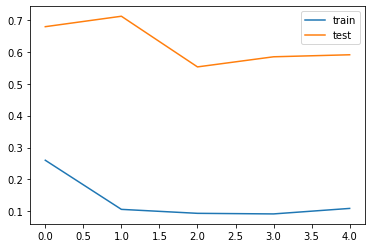

In [61]:
model = fit_and_plot(model, generator.getTrainData(), generator.getValidationData(), epochs=5)

100%|██████████| 23/23 [00:01<00:00, 18.44it/s]


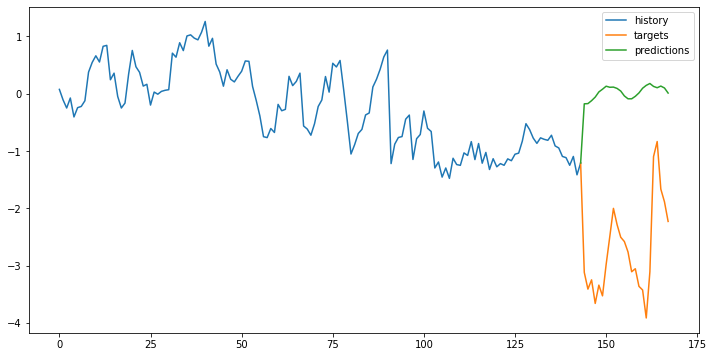

100%|██████████| 23/23 [00:01<00:00, 19.80it/s]


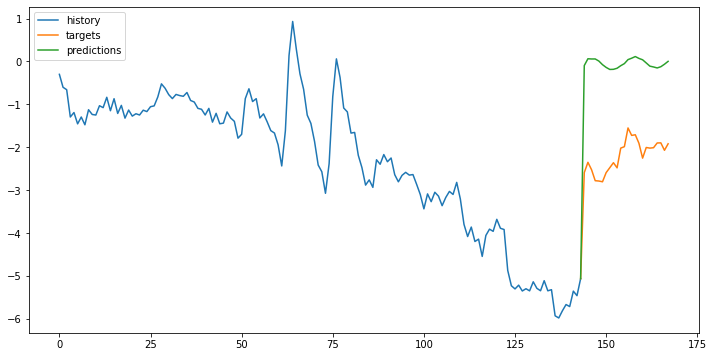

100%|██████████| 23/23 [00:01<00:00, 21.93it/s]


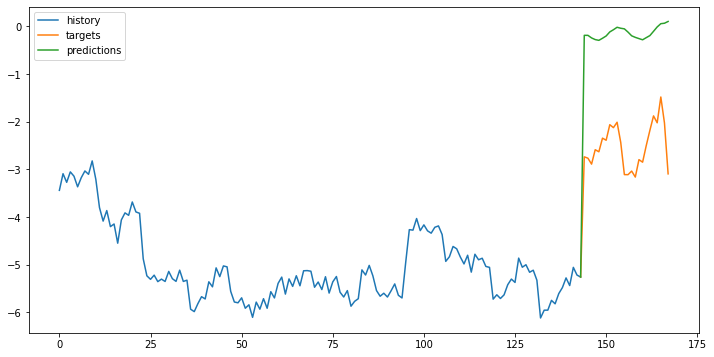

100%|██████████| 23/23 [00:01<00:00, 22.46it/s]


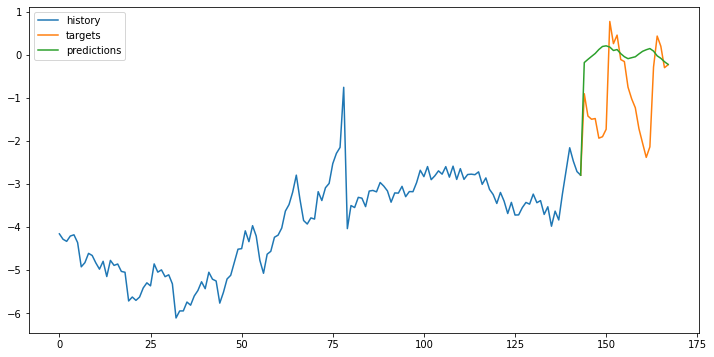

100%|██████████| 23/23 [00:01<00:00, 22.49it/s]


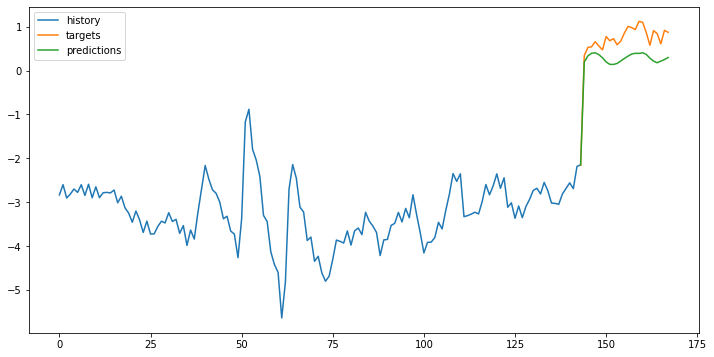

100%|██████████| 23/23 [00:01<00:00, 21.59it/s]


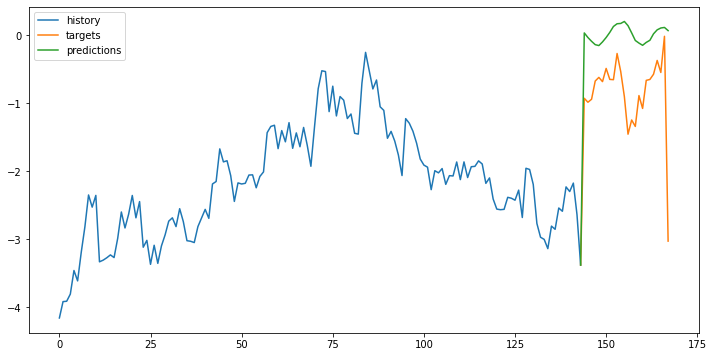

100%|██████████| 23/23 [00:01<00:00, 21.56it/s]


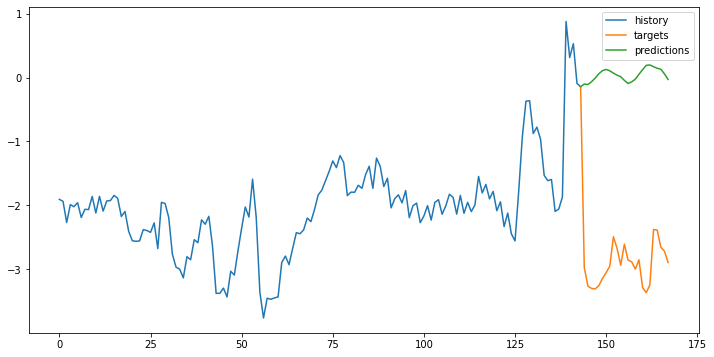

100%|██████████| 23/23 [00:01<00:00, 22.02it/s]


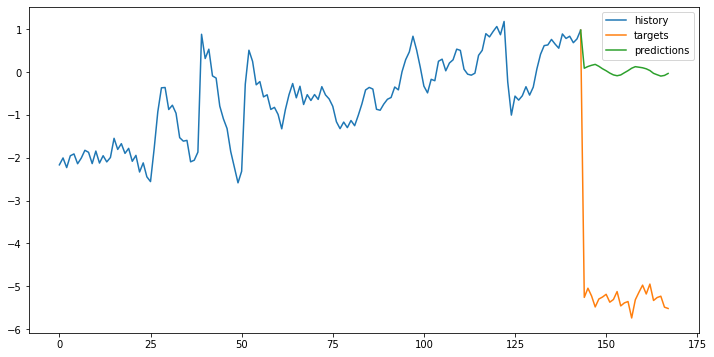

In [50]:
generator.predict_and_plot(model, data_raw=validation_data, start_positions=[0,100, 200, 300, 400, 500, 600, 700], save_plot=False)

In [47]:
tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
